In [10]:
pip install numpy pandas matplotlib seaborn scikit-learn imbalanced-learn pyod hyperopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 55.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 48.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 43.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.utils import shuffle
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, auc, roc_curve, precision_recall_curve, balanced_accuracy_score
)
from imblearn.over_sampling import SMOTE
from pyod.models.cblof import CBLOF
from hyperopt import Trials, STATUS_OK, fmin, tpe, hp

warnings.filterwarnings("ignore")
sns.set(style='whitegrid')

In [15]:
# Data Load
df = pd.read_csv('DG_out.csv', sep=',')
df.head()

tx_hash  indegree  outdegree  \
0  0437cd7f8525ceed2324359c2d0ba26006d92d856a9c20...         0          1   
1  f4184fc596403b9d638783cf57adfe4c75c605f6356fbc...         1          2   
2  ea44e97271691990157559d0bdd9959e02790c34db6c00...         1          1   
3  a16f3ce4dd5deb92d98ef5cf8afeaf0775ebca408f708b...         1          1   
4  591e91f809d716912ca1d4a9295e70c3e78bab077683f7...         1          2   

   in_btc  out_btc  total_btc  mean_in_btc  mean_out_btc  in_malicious  \
0     0.0     50.0       50.0          0.0          50.0             0   
1    50.0     50.0      100.0         50.0          25.0             0   
2    10.0     10.0       20.0         10.0          10.0             0   
3    40.0     30.0       70.0         40.0          30.0             0   
4    30.0     30.0       60.0         30.0          15.0             0   

   out_malicious  is_malicious  out_and_tx_malicious  all_malicious  
0              0             0                     0              0  
1              0             0                     0              0  
2              0             0                     0              0  
3              0             0                     0              0  
4              0             0                     0              0

In [16]:
df.drop(['tx_hash', 'in_malicious', 'out_malicious', 'is_malicious', 'all_malicious'], axis=1, inplace=True)
df.describe()

indegree     outdegree        in_btc       out_btc     total_btc  \
count  3.024813e+07  3.024813e+07  3.024813e+07  3.024813e+07  3.024813e+07   
mean   2.148699e+00  2.148699e+00  5.484150e+01  5.484150e+01  1.096830e+02   
std    7.421447e+00  4.512048e+00  1.303303e+03  1.301473e+03  2.602527e+03   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.000000e+00  2.000000e+00  1.000000e-01  9.950000e-02  2.058720e-01   
50%    1.000000e+00  2.000000e+00  9.325000e-01  9.590000e-01  1.964759e+00   
75%    2.000000e+00  2.000000e+00  8.591912e+00  9.063657e+00  1.840000e+01   
max    1.932000e+03  1.322000e+03  5.500000e+05  5.000207e+05  1.050000e+06   

        mean_in_btc  mean_out_btc  out_and_tx_malicious  
count  3.024813e+07  3.024813e+07          3.024813e+07  
mean   4.923980e+01  2.877087e+01          3.570468e-06  
std    9.729210e+02  7.125567e+02          1.889565e-03  
min    0.000000e+00  0.000000e+00          0.000000e+00  
25%    6.400000e-02  5.025776e-02          0.000000e+00  
50%    5.350261e-01  4.900000e-01          0.000000e+00  
75%    5.614287e+00  4.519481e+00          0.000000e+00  
max    4.992596e+05  5.000000e+05          1.000000e+00

In [17]:
# Class Distribution
print(f'No Frauds: {round(df["out_and_tx_malicious"].value_counts()[0]/len(df) * 100,2)}% of the dataset')
print(f'Frauds: {round(df["out_and_tx_malicious"].value_counts()[1]/len(df) * 100,5)}% of the dataset')

No Frauds: 100.0% of the dataset
Frauds: 0.00036% of the dataset


In [19]:
df['out_and_tx_malicious'].value_counts()

out_and_tx_malicious
0    30248026
1         108
Name: count, dtype: int64

In [20]:
# Log Scale Transformation
for col in ['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc']:
    df[col] = np.log1p(df[col])

In [21]:
# Scaling
scaler = RobustScaler()
for col in df.columns[:-1]:
    df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))

In [22]:
# Split Dataset
X = df.iloc[:, :-1].values
y = df['out_and_tx_malicious'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [23]:
# Sample Function
def get_sample(X, y, n):
    normal_indices = np.where(y == 0)[0]
    fraud_indices = np.where(y == 1)[0]
    normal_sample_indices = np.random.choice(normal_indices, n, replace=False)
    sample_indices = np.concatenate([normal_sample_indices, fraud_indices])
    return shuffle(X[sample_indices], y[sample_indices])


In [24]:
# Oversample Function
def oversample_minority(X, y, fraction):
    smote = SMOTE(sampling_strategy=fraction, n_jobs=-1)
    return smote.fit_resample(X, y)

In [25]:
# Evaluation Function
def evaluate_metrics(actual, predicted, scores, time_elapsed):
    metrics = {
        'time': time_elapsed,
        'conf_matrix': confusion_matrix(actual, predicted),
        'balanced_accuracy': balanced_accuracy_score(actual, predicted),
        'accuracy': accuracy_score(actual, predicted),
        'macro_precision': precision_score(actual, predicted, average='macro'),
        'macro_recall': recall_score(actual, predicted, average='macro'),
        'macro_f1': f1_score(actual, predicted, average='macro'),
        'macro_roc': roc_auc_score(actual, scores, average='macro'),
        'precision': precision_score(actual, predicted),
        'recall': recall_score(actual, predicted),
        'f1': f1_score(actual, predicted),
        'roc': roc_auc_score(actual, scores)
    }
    fpr, tpr, _ = roc_curve(actual, scores)
    metrics.update({
        'false_pos_rate': fpr,
        'true_pos_rate': tpr,
        'precision_rt': precision_recall_curve(actual, scores)[0],
        'recall_rt': precision_recall_curve(actual, scores)[1],
        'threshold_rt': precision_recall_curve(actual, scores)[2]
    })
    return metrics

In [45]:
# Save Model Function
def save_model(model, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)

In [46]:
# Save Model Function
#Check if the directory exists, if not, create it 
#directory = './Models/CBLOF/'
#if not os.path.exists(directory): 
 #   os.makedirs(directory)

# Iterate over models and save them 
#for k in models:
    #with open(directory + 'k=' + str(k) + '.h5', 'wb') as file: 
    #    pickle.dump(models.get(k), file)

In [47]:
# Fit Model Function
def fit_cblof(X_train, outlier_fraction, random_state=42):
    model = CBLOF(n_clusters=8, contamination=outlier_fraction, alpha=0.839, beta=2, random_state=random_state, n_jobs=-1)
    model.fit(X_train)
    return model

In [48]:
# Training Parameters
iterations = 20
training_sample_size = len(y_train) // 10
oversampling_fraction = 0.2356
model_dir = './Models/CBLOF/'

print(f'Training Parameters:\nIterations: {iterations}\nTraining Sample Size: {training_sample_size}\nOversampling Fraction: {oversampling_fraction}')

Training Parameters:
Iterations: 20
Training Sample Size: 2419850
Oversampling Fraction: 0.2356


In [49]:
# Ensure model directory exists
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [51]:
import time
import h5py
from pyod.models.cblof import CBLOF

# Iterative Training and Evaluation
training_evaluations = {}
test_evaluations = {}
models = {}

for i in range(iterations):
    X_sample, y_sample = get_sample(X_train, y_train, training_sample_size)
    X_resampled, y_resampled = oversample_minority(X_sample, y_sample, oversampling_fraction)

    start_time = time.time()
    model = fit_cblof(X_resampled, outlier_fraction=oversampling_fraction)
    end_time = time.time()

    model_filename = f'{model_dir}model_{i+1}.h5'
    save_model(model, model_filename)  # Save model in HDF5 format using PyOD

    y_train_pred = model.labels_
    y_train_scores = model.decision_scores_

    train_time = end_time - start_time
    training_evaluations[i+1] = evaluate_metrics(y_resampled, y_train_pred, y_train_scores, train_time)

    test_start = time.time()
    y_test_pred = model.predict(X_test)
    y_test_scores = model.decision_function(X_test)
    test_end = time.time()

    test_time = test_end - test_start
    test_evaluations[i+1] = evaluate_metrics(y_test, y_test_pred, y_test_scores, test_time)

    print(f'Iteration {i+1}/{iterations} - Training Time: {train_time:.4f}s - Testing Time: {test_time:.4f}s')

print('Iterative Training Completed!')


Iteration 1/20 - Training Time: 1.3563s - Testing Time: 1.1495s
Iteration 2/20 - Training Time: 1.5475s - Testing Time: 1.2268s
Iteration 3/20 - Training Time: 1.6190s - Testing Time: 1.3201s
Iteration 4/20 - Training Time: 1.5542s - Testing Time: 1.1333s
Iteration 5/20 - Training Time: 1.5059s - Testing Time: 1.1856s
Iteration 6/20 - Training Time: 1.3926s - Testing Time: 1.1357s
Iteration 7/20 - Training Time: 1.4099s - Testing Time: 1.1955s
Iteration 8/20 - Training Time: 1.3636s - Testing Time: 1.6282s
Iteration 9/20 - Training Time: 1.3905s - Testing Time: 1.0795s
Iteration 10/20 - Training Time: 1.5279s - Testing Time: 1.0668s
Iteration 11/20 - Training Time: 1.5110s - Testing Time: 1.2154s
Iteration 12/20 - Training Time: 1.9451s - Testing Time: 1.2258s
Iteration 13/20 - Training Time: 1.5206s - Testing Time: 1.1548s
Iteration 14/20 - Training Time: 1.4565s - Testing Time: 1.2160s
Iteration 15/20 - Training Time: 1.3656s - Testing Time: 1.1096s
Iteration 16/20 - Training Time: 1

In [52]:
import pandas as pd

# Convert Evaluations to DataFrame
def evaluations_to_df(evaluations):
    columns = ['Iteration', 'Accuracy', 'Balanced-Accuracy', 'Macro-Precision', 'Macro-Recall', 'Macro-F1', 'Macro-ROC', 'Precision', 'Recall', 'F1', 'ROC', 'Time']
    data = []
    for key, metrics in evaluations.items():
        data.append({
            'Iteration': key,
            'Accuracy': metrics['accuracy'],
            'Balanced-Accuracy': metrics['balanced_accuracy'],
            'Macro-Precision': metrics['macro_precision'],
            'Macro-Recall': metrics['macro_recall'],
            'Macro-F1': metrics['macro_f1'],
            'Macro-ROC': metrics['macro_roc'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1': metrics['f1'],
            'ROC': metrics['roc'],
            'Time': metrics['time']
        })
    df_eval = pd.DataFrame(data, columns=columns)
    return df_eval

train_eval_df = evaluations_to_df(training_evaluations)
test_eval_df = evaluations_to_df(test_evaluations)


In [53]:
# Visualization
def plot_metrics(metrics, training_evals, testing_evals):
    for metric in metrics:
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        iterations = list(training_evals.keys())
        train_results = [training_evals[i][metric] for i in iterations]
        test_results = [testing_evals[i][metric] for i in iterations]
        
        axes[0].plot(iterations, train_results, label=f'Training {metric}', linewidth=3)
        axes[0].set_title(f'Training {metric}')
        axes[0].set_xlabel('Iterations')
        axes[0].set_ylabel(metric)
        
        axes[1].plot(iterations, test_results, label=f'Validation {metric}', linewidth=3, color='g')
        axes[1].set_title(f'Validation {metric}')
        axes[1].set_xlabel('Iterations')
        axes[1].set_ylabel(metric)
        
        plt.figure(figsize=(8, 5))
        plt.plot(iterations, train_results, label=f'Training {metric}', linewidth=3)
        plt.plot(iterations, test_results, label=f'Validation {metric}', linewidth=3, color='g')
        plt.legend()
        plt.title(metric)
        plt.xlabel('Iterations')
        plt.ylabel(metric)
        plt.show()

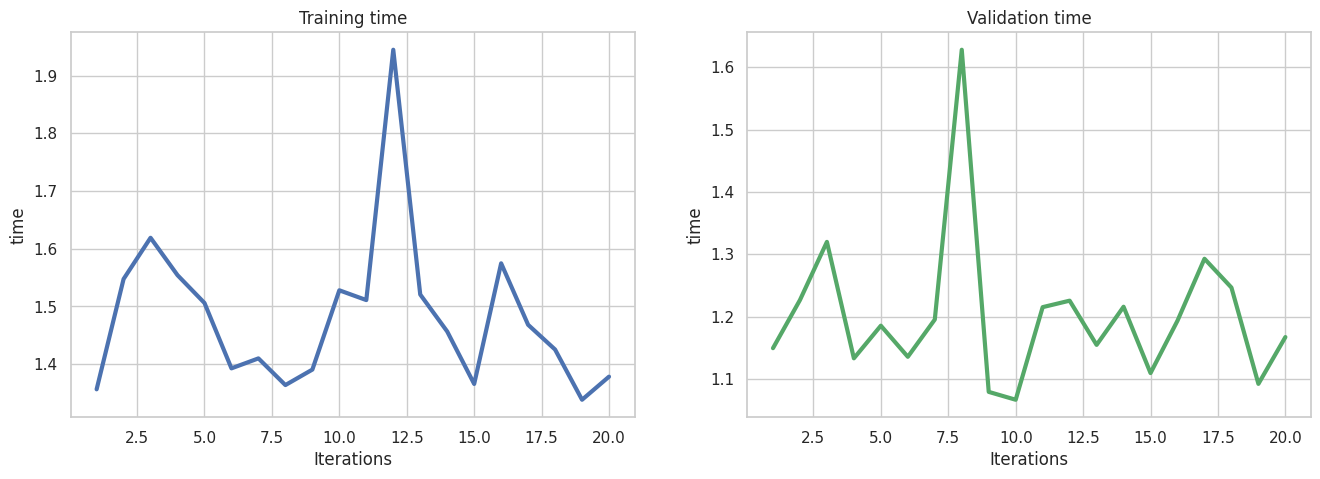

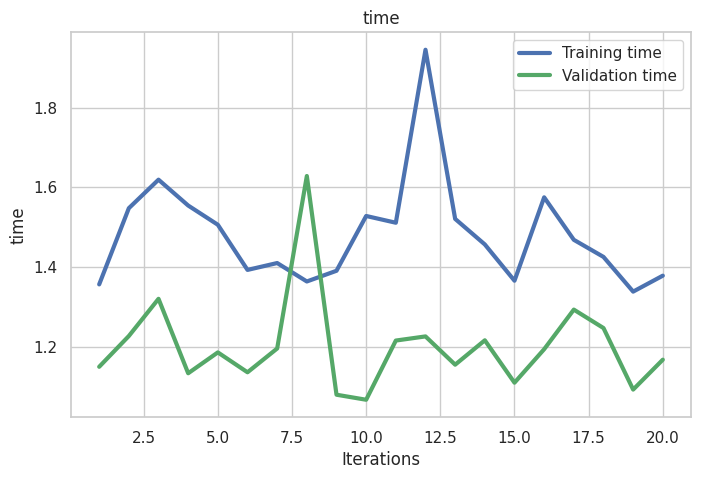

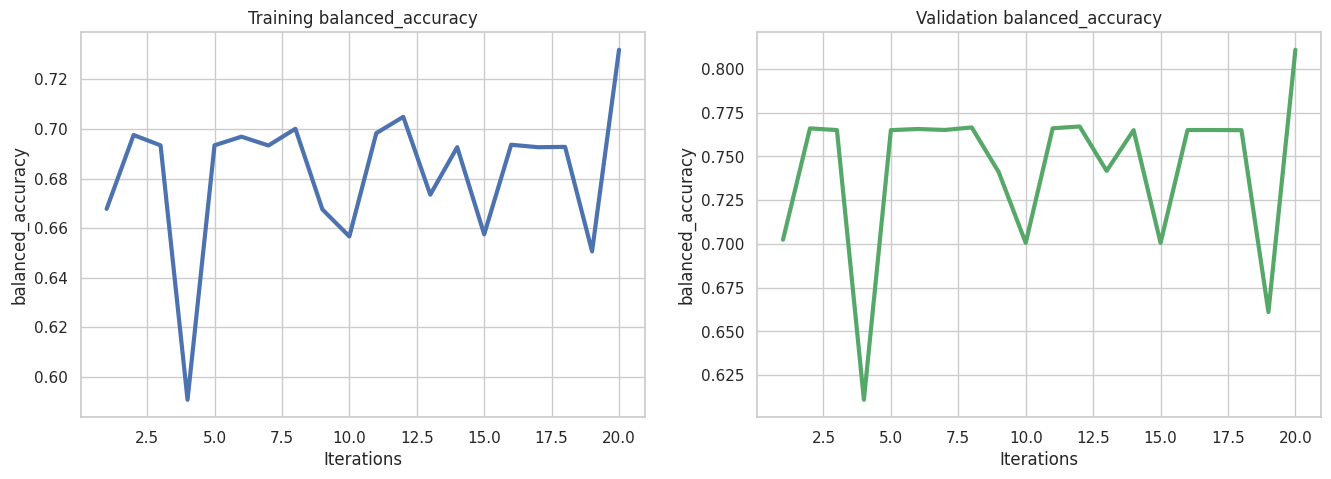

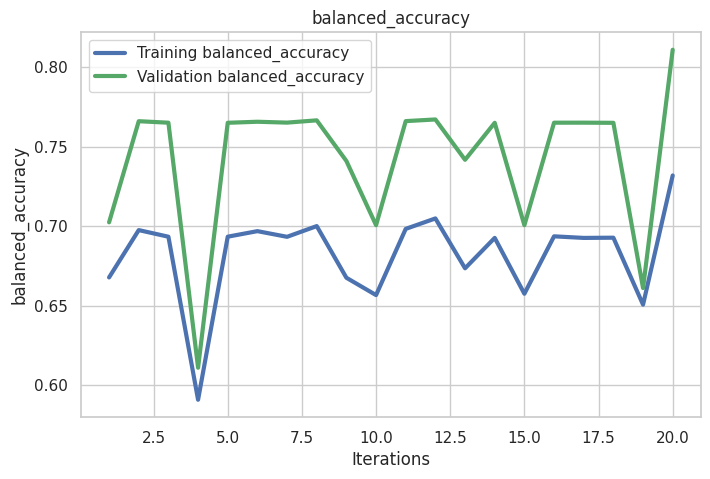

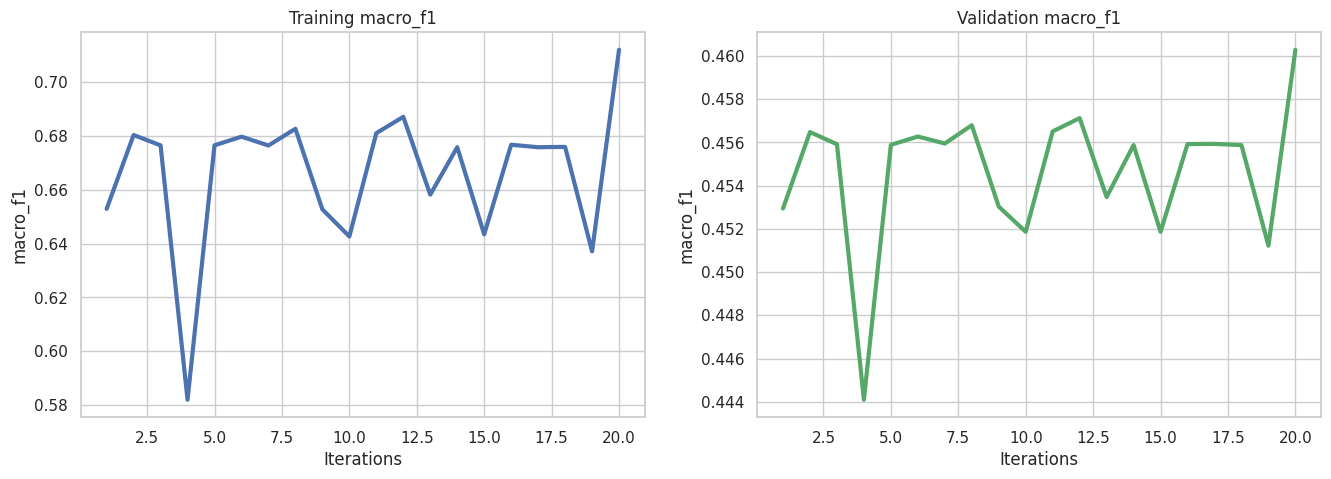

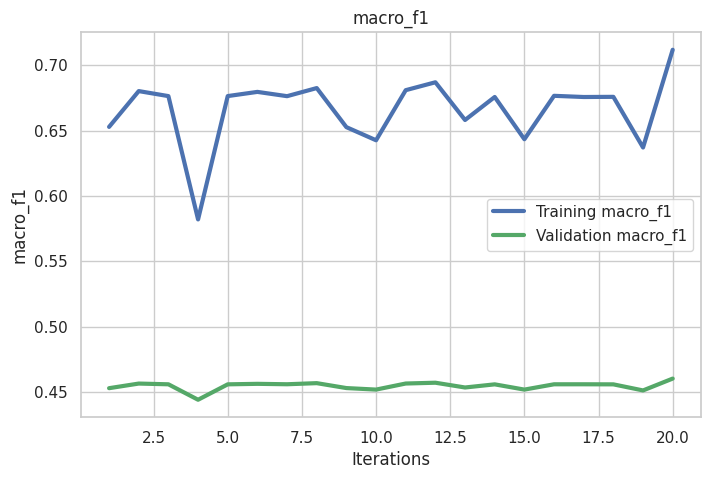

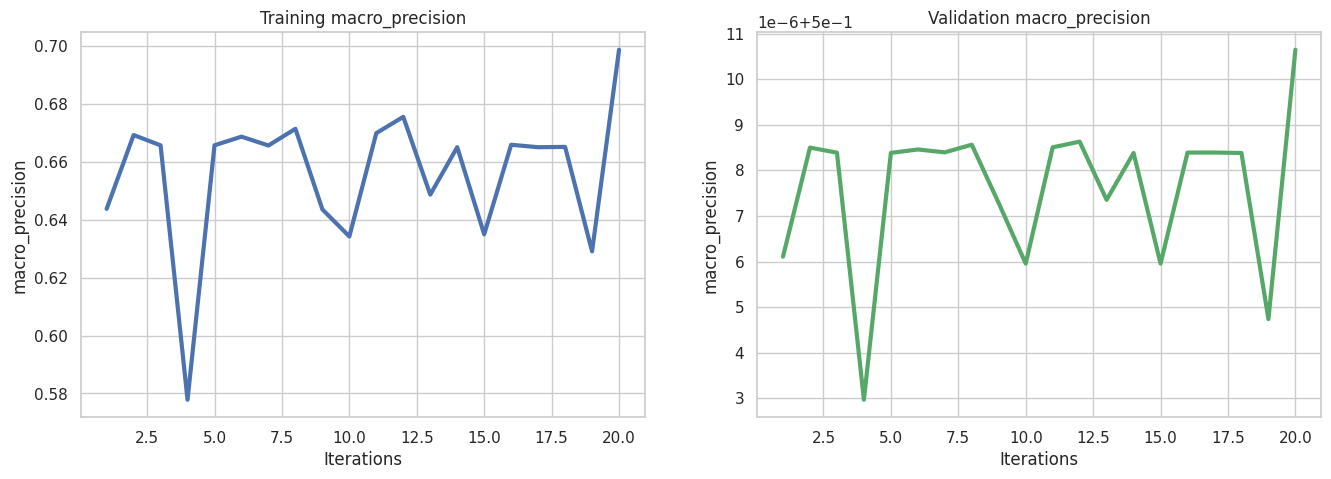

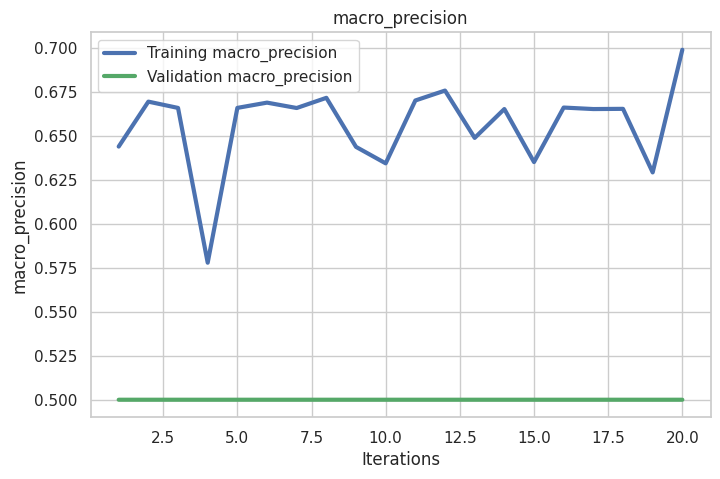

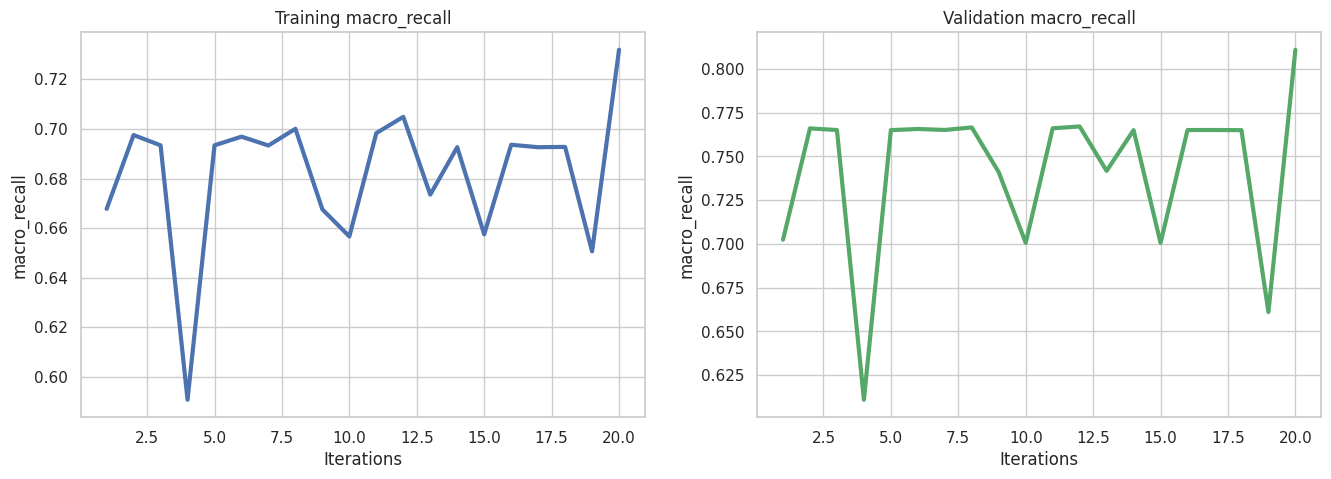

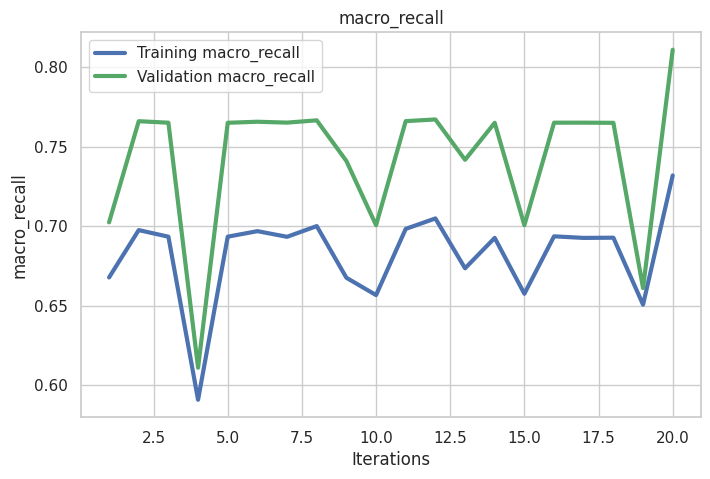

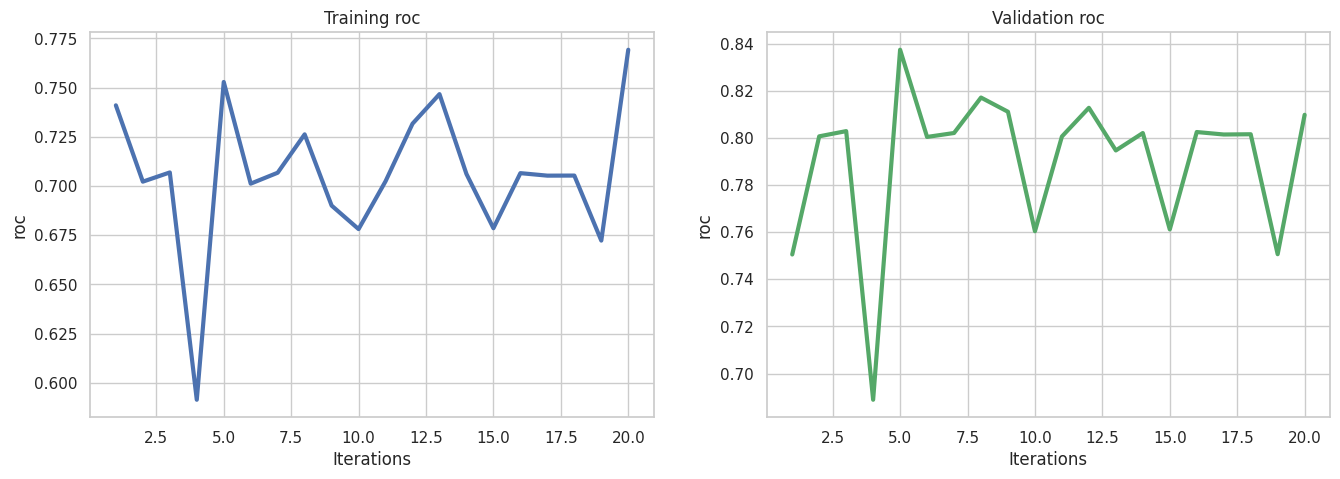

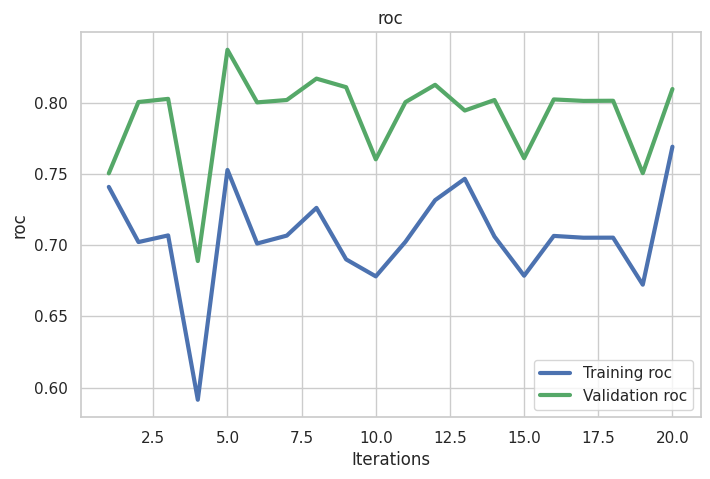

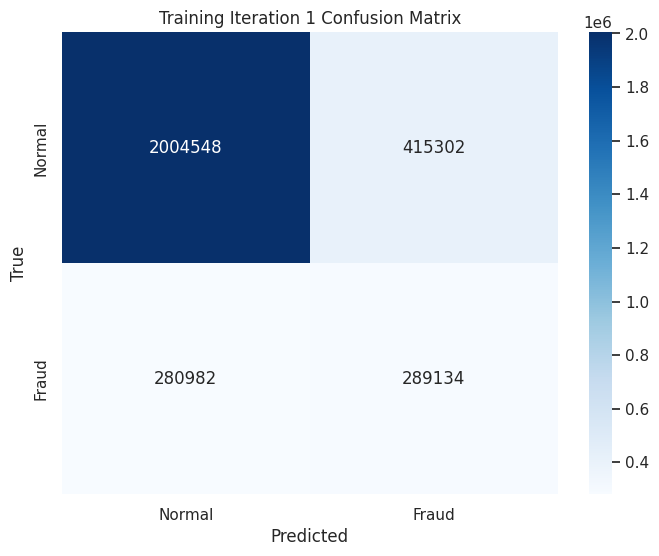

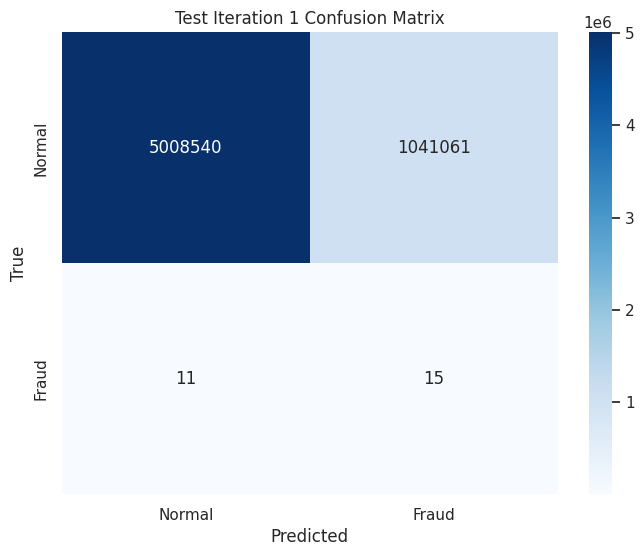

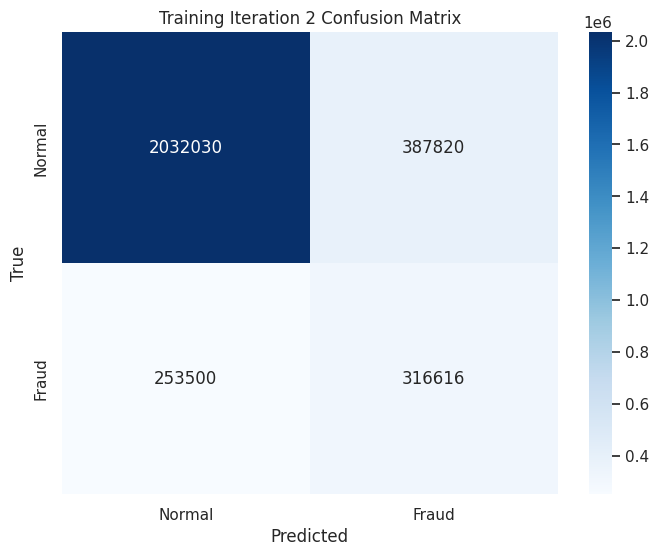

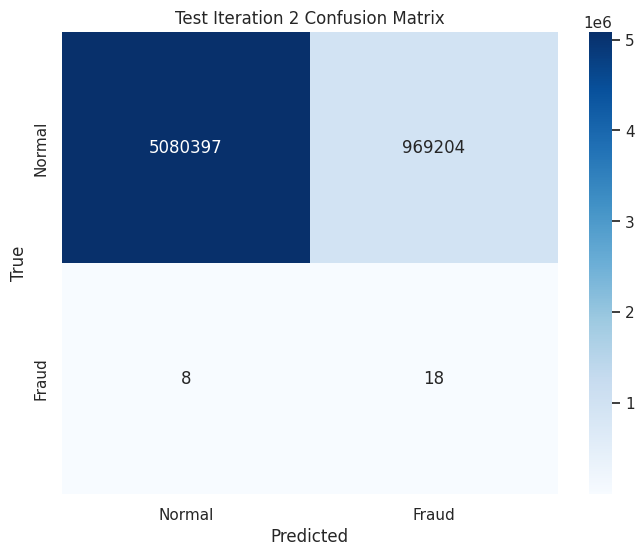

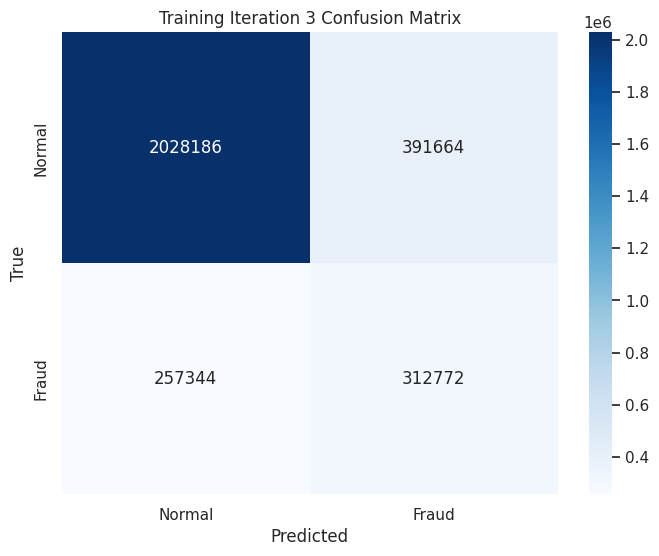

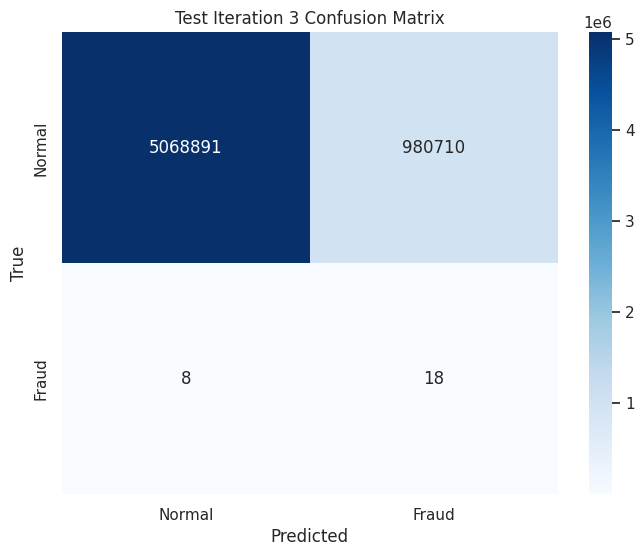

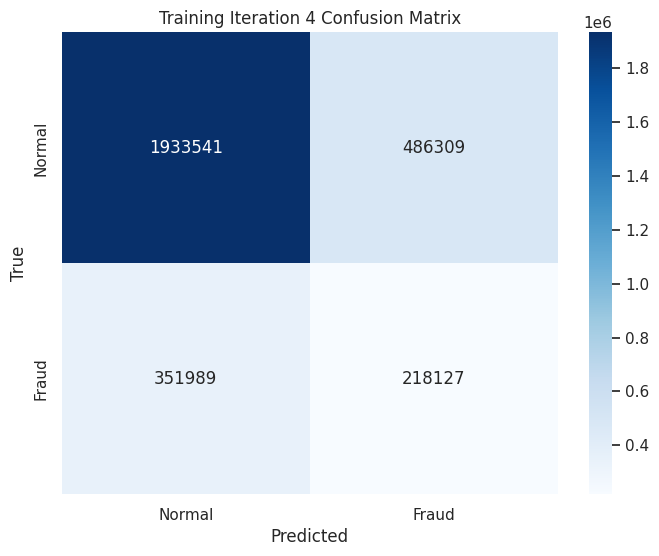

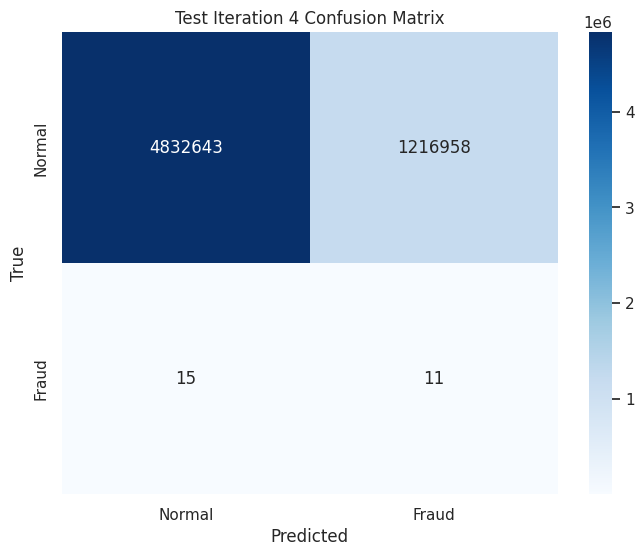

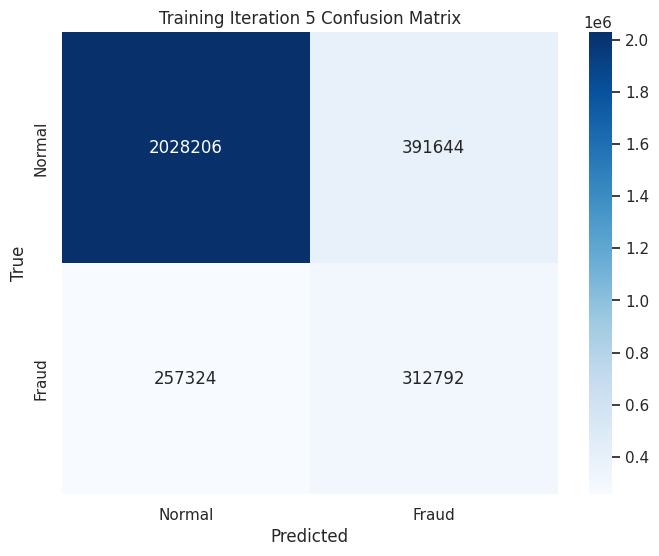

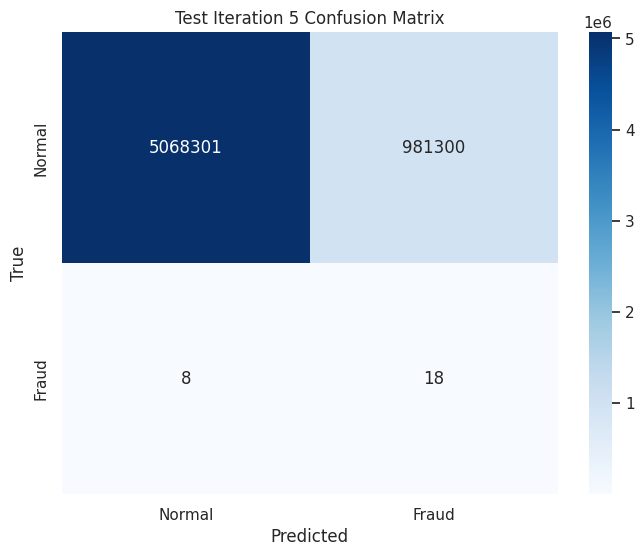

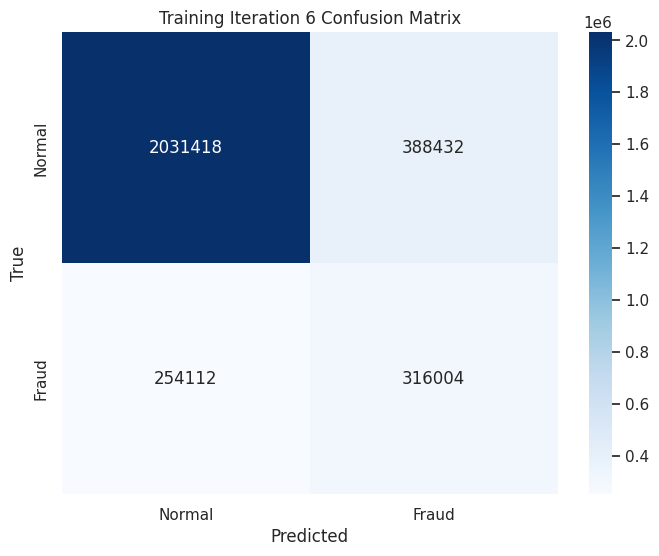

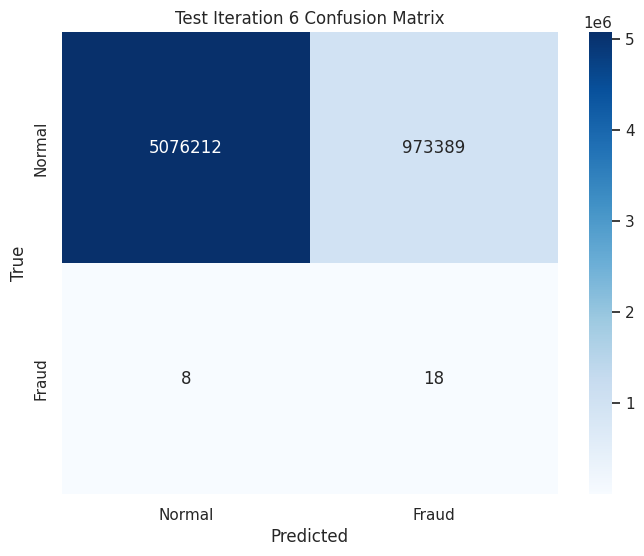

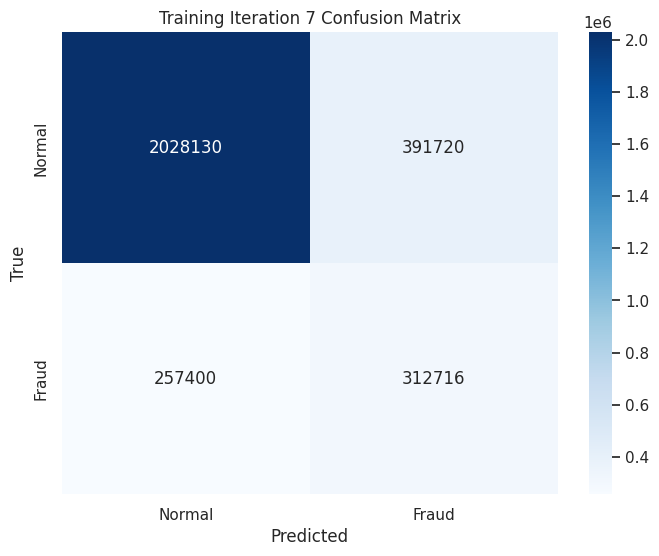

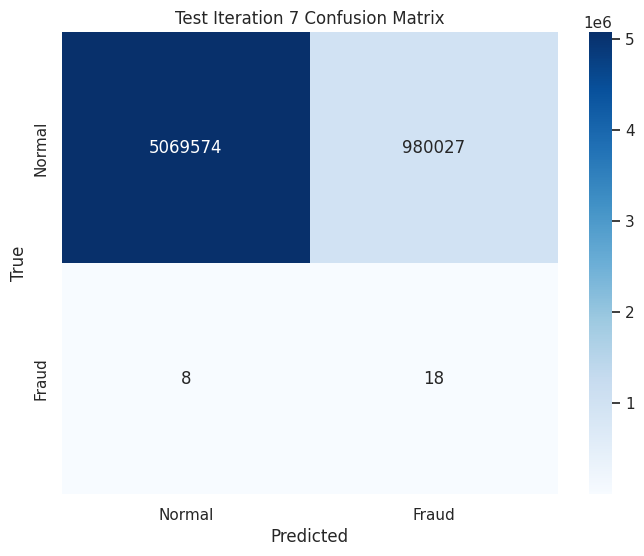

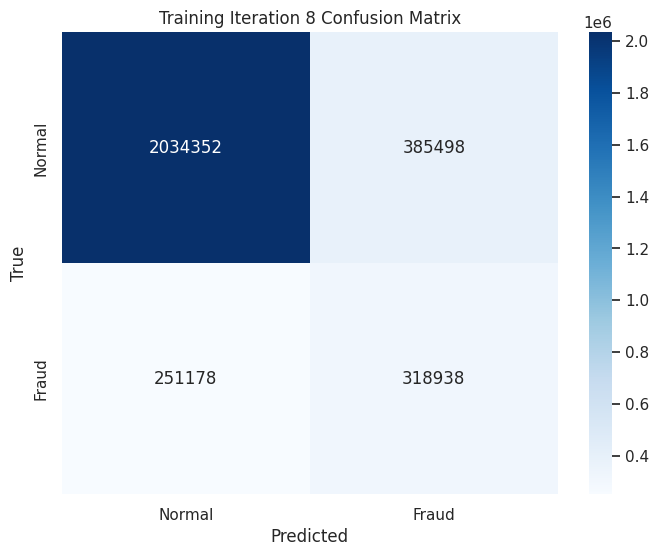

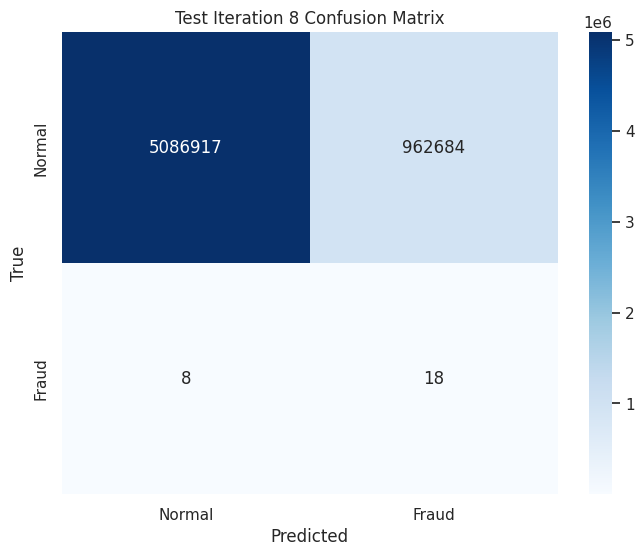

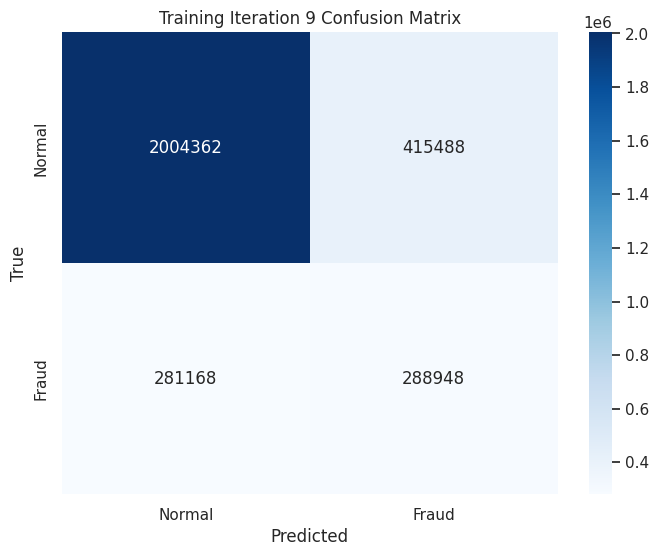

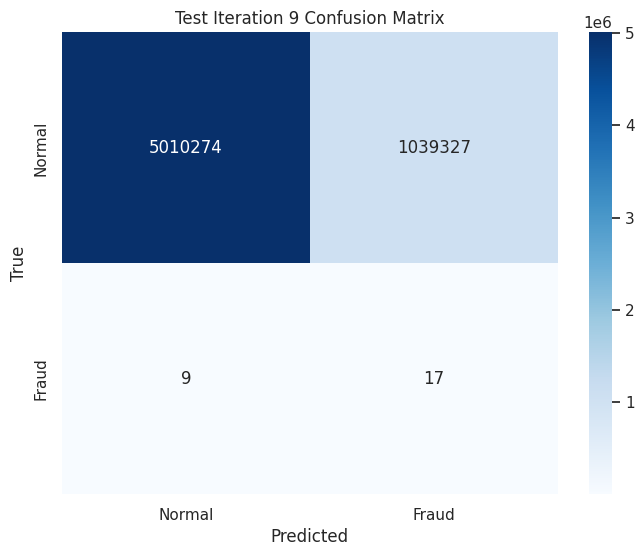

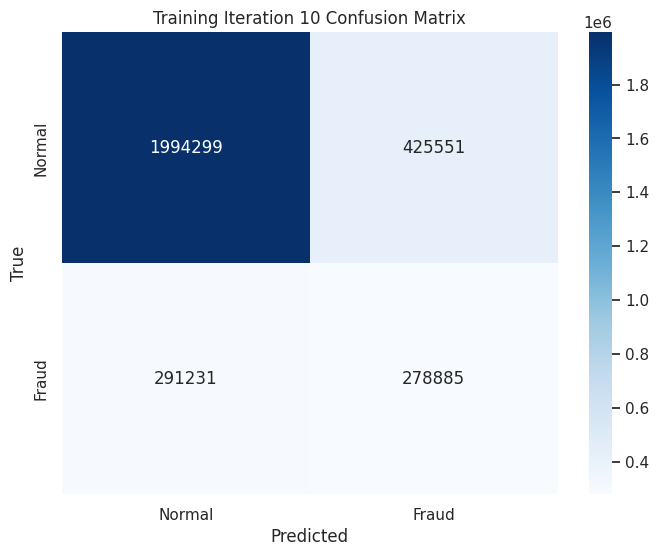

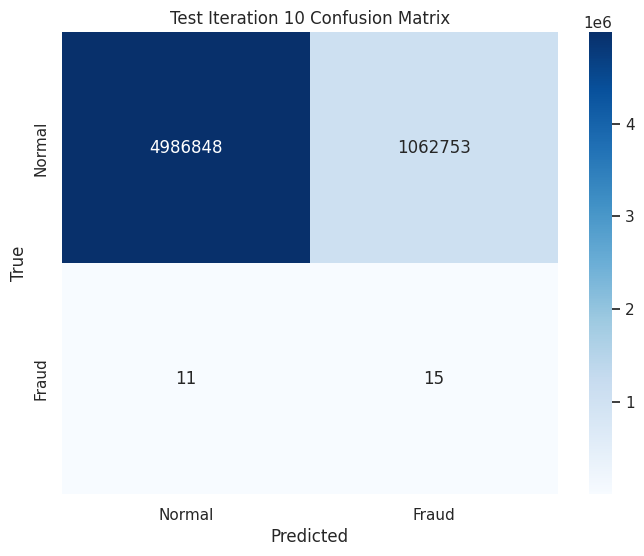

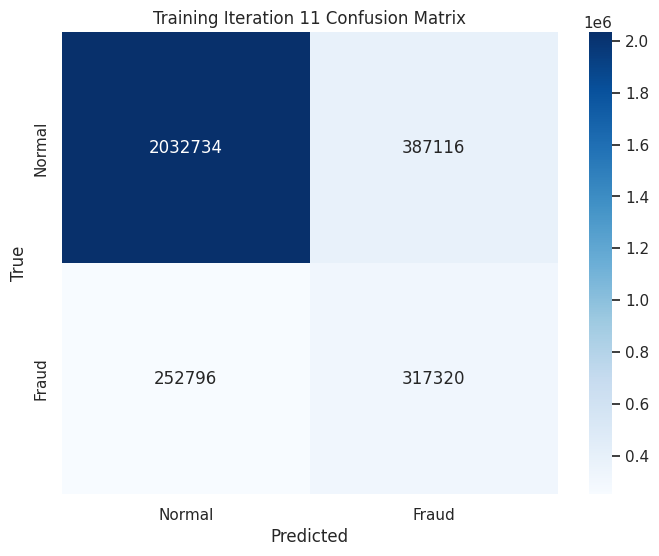

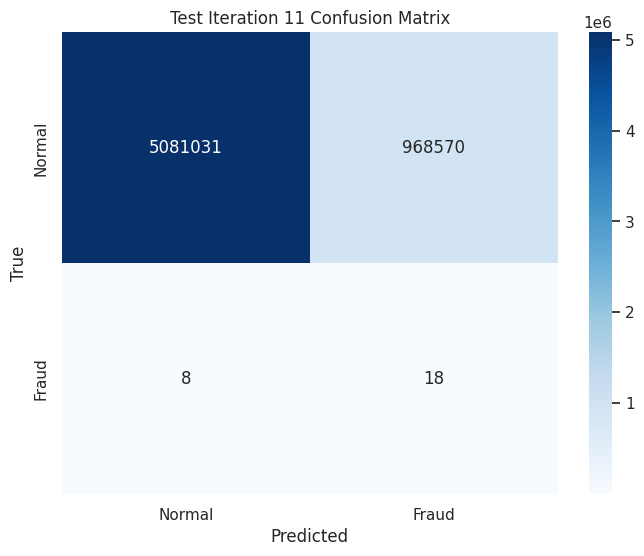

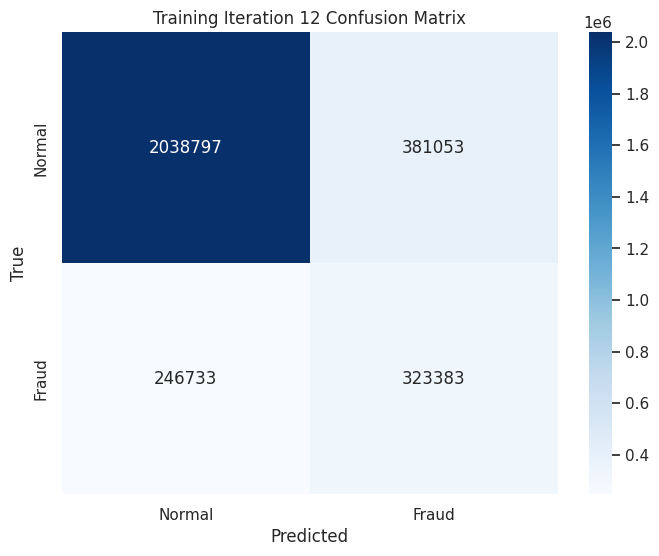

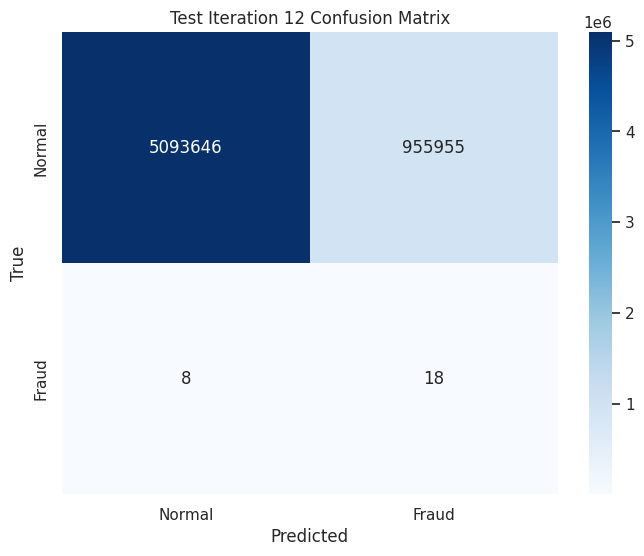

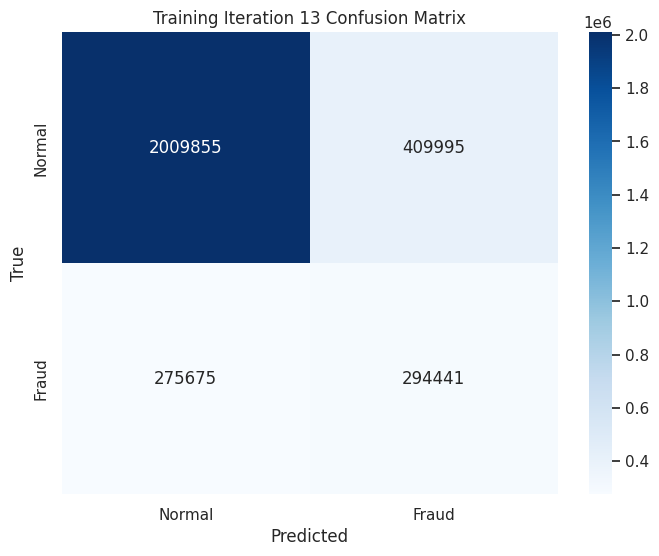

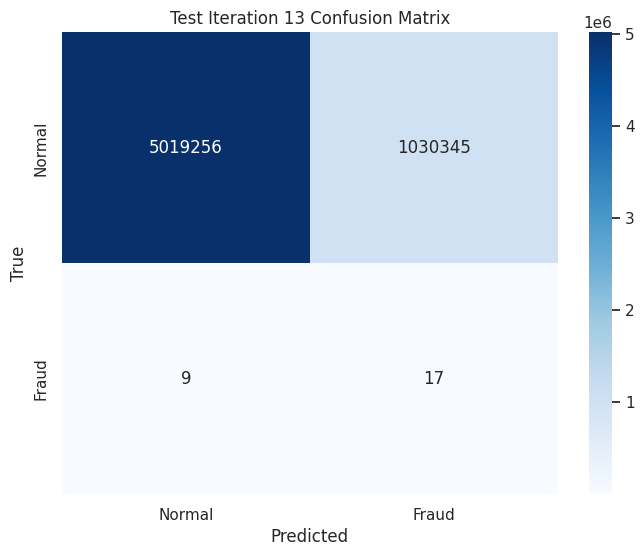

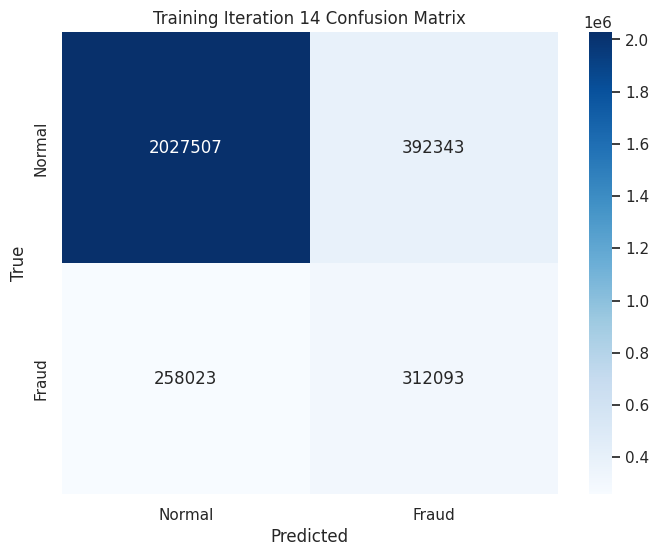

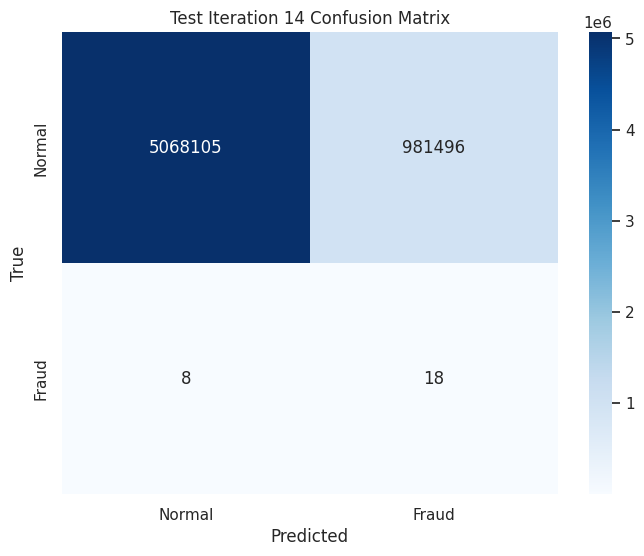

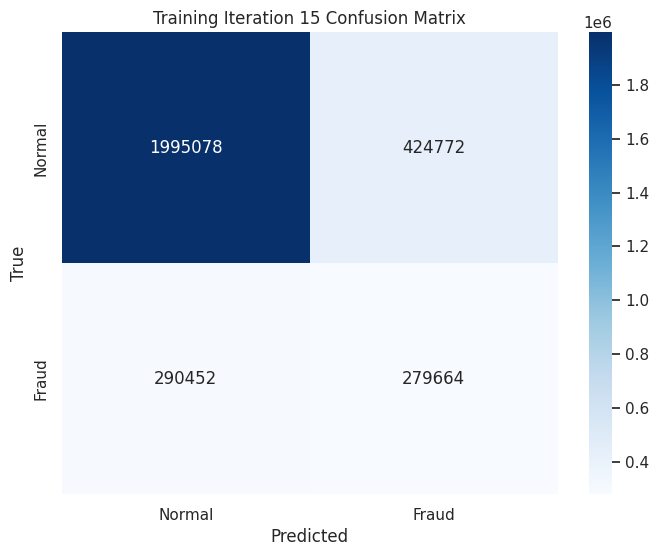

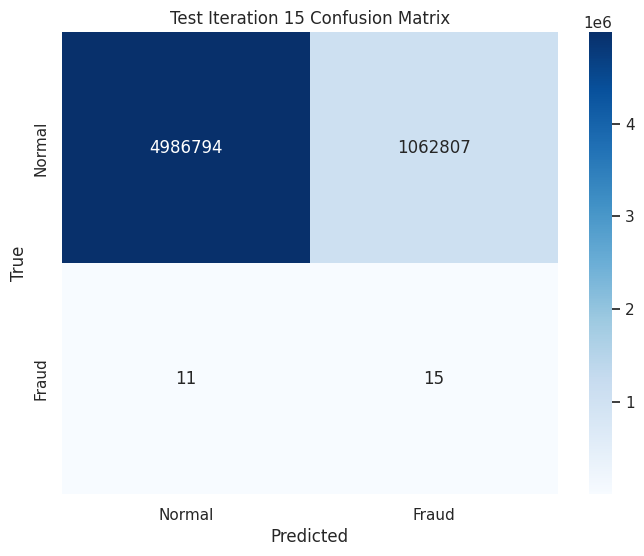

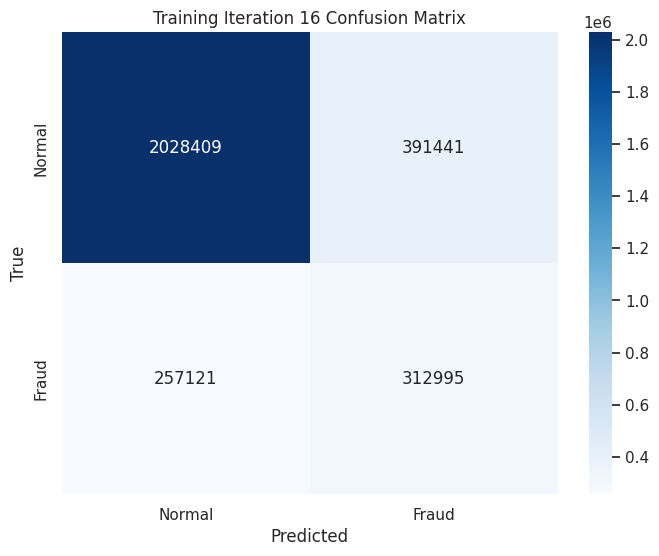

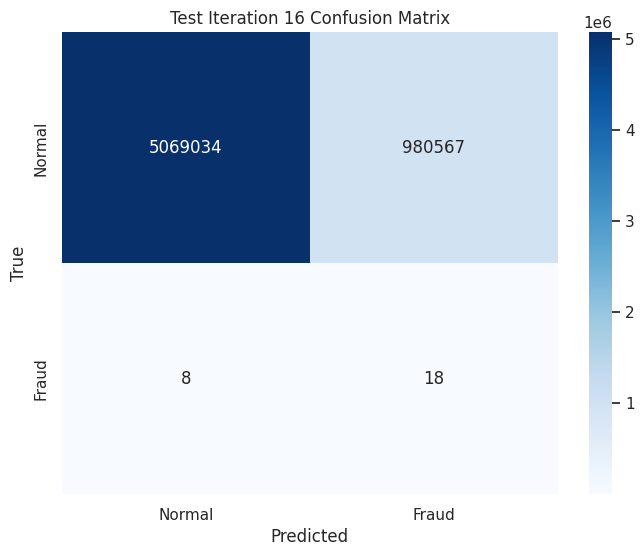

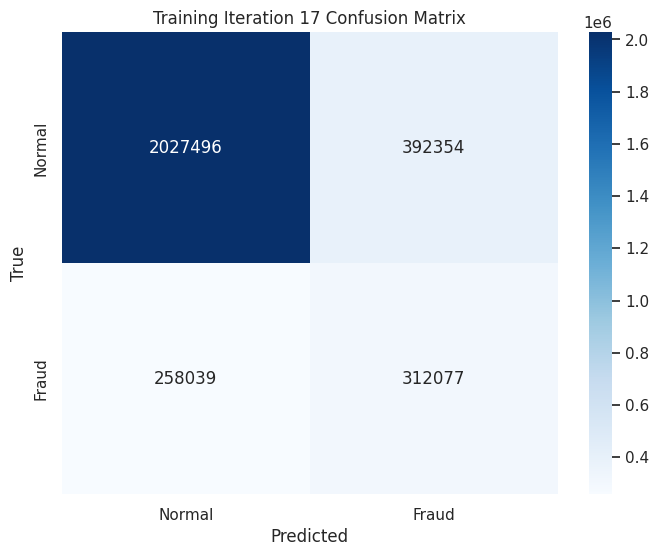

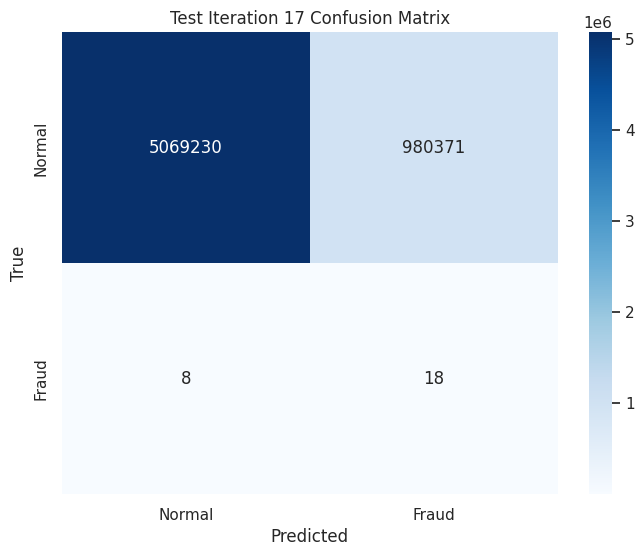

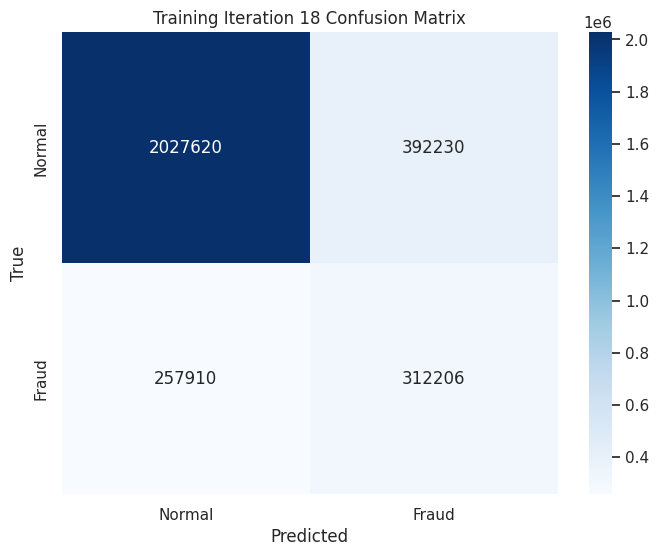

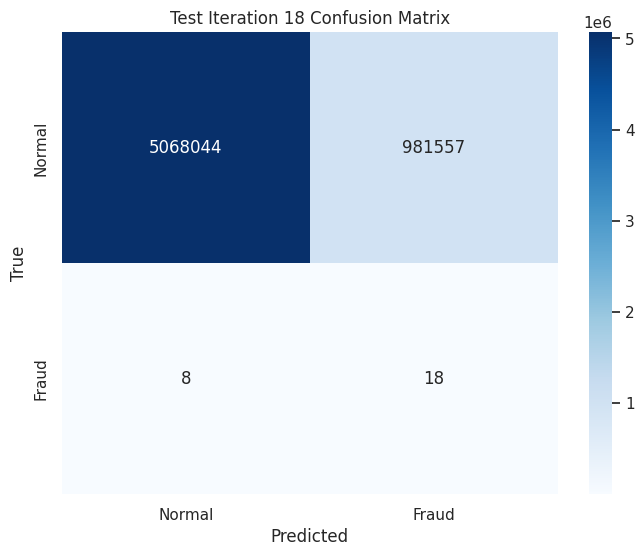

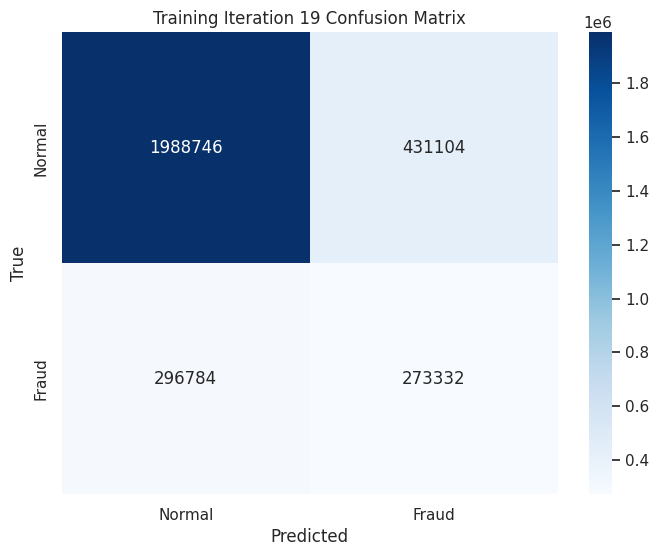

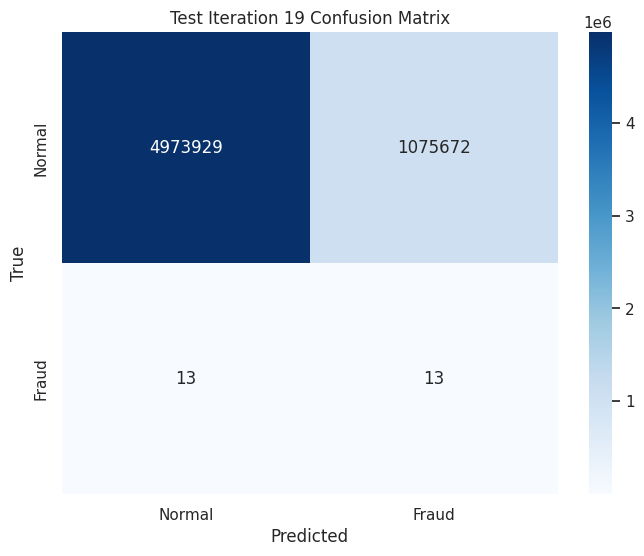

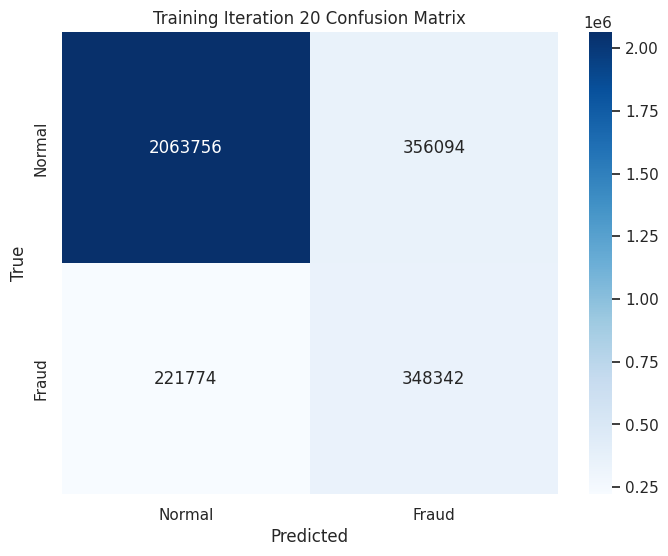

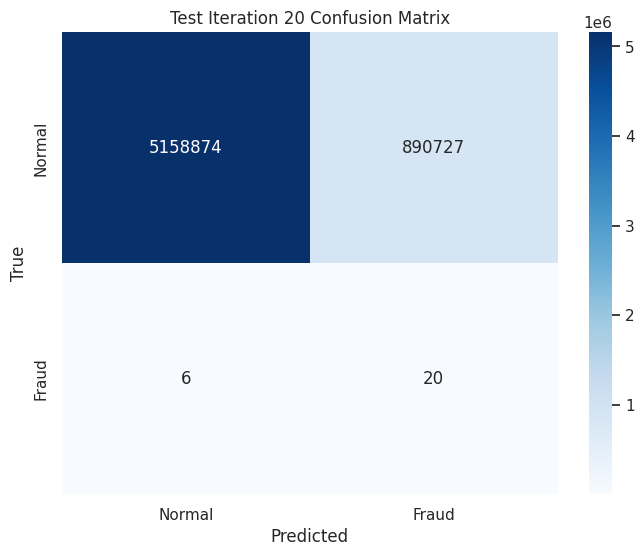

In [54]:
# Plot Selected Metrics
metrics_to_plot = ['time', 'balanced_accuracy', 'macro_f1', 'macro_precision', 'macro_recall', 'roc']
plot_metrics(metrics_to_plot, training_evaluations, test_evaluations)

# Confusion Matrix Visualization
def plot_confusion_matrix(cm, title, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

labels = ['Normal', 'Fraud']

for it in range(1, iterations + 1):
    cm_train = training_evaluations[it]['conf_matrix']
    cm_test = test_evaluations[it]['conf_matrix']
    plot_confusion_matrix(cm_train, f'Training Iteration {it} Confusion Matrix', labels)
    plot_confusion_matrix(cm_test, f'Test Iteration {it} Confusion Matrix', labels)


In [55]:
# Parameter Tuning using Hyperopt
def hyperopt_tuning(space):
    start_time = time.time()
    n_clusters = int(space['n_clusters'])
    outliers_fraction = space['outliers_fraction']
    alpha = space['alpha']
    beta = space['beta']
    
    X_sample, y_sample = get_sample(X_train, y_train, training_sample_size)
    X_resampled, y_resampled = oversample_minority(X_sample, y_sample, outliers_fraction)
    
    model = CBLOF(n_clusters=n_clusters, contamination=outliers_fraction, alpha=alpha, beta=beta, random_state=42, n_jobs=-1)
    model.fit(X_resampled)
    
    y_pred = model.labels_
    score = f1_score(y_resampled, y_pred, average='macro')
    loss = 1 - score
    
    end_time = time.time()
    print(f'Parameters: {space}, Loss: {loss}, Time: {end_time - start_time:.4f}s')
    
    return {'loss': loss, 'status': STATUS_OK}

space = {
    'n_clusters': hp.uniform('n_clusters', 3, 14),
    'outliers_fraction': hp.uniform('outliers_fraction', 0.05, 0.25),
    'alpha': hp.uniform('alpha', 0.1, 0.9),
    'beta': hp.uniform('beta', 1, 15)
}

trials = Trials()
best_params = fmin(fn=hyperopt_tuning, space=space, algo=tpe.suggest, max_evals=500, trials=trials)

print(f'Best Parameters: {best_params}')

Parameters: {'alpha': 0.7658598240482719, 'beta': 3.0928832243878714, 'n_clusters': 3.5175079711524737, 'outliers_fraction': 0.054715858990605784}, Loss: 0.3623771429830923, Time: 11.1099s
Parameters: {'alpha': 0.19100113354210357, 'beta': 11.378488387536844, 'n_clusters': 7.7062708253654835, 'outliers_fraction': 0.11342981187454436}, Loss: 0.2660838816765725, Time: 10.4274s
Parameters: {'alpha': 0.4952049858684431, 'beta': 5.327023065078317, 'n_clusters': 13.214421709187246, 'outliers_fraction': 0.14310223088065588}, Loss: 0.35805165317632204, Time: 10.5759s
Parameters: {'alpha': 0.4230869278177547, 'beta': 2.4805892404581535, 'n_clusters': 6.976919584400462, 'outliers_fraction': 0.14337009658334202}, Loss: 0.2276935319427611, Time: 10.1876s
Parameters: {'alpha': 0.1272694647529317, 'beta': 8.000470307641963, 'n_clusters': 6.324470771261596, 'outliers_fraction': 0.07277021749685403}, Loss: 0.26226324088047304, Time: 12.2183s
Parameters: {'alpha': 0.692159608493607, 'beta': 11.51798849